In [25]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json

In [ ]:
def ground_truth_is(json_file, image_shape):
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Initialize an empty mask with the image shape
    ground_truth_mask = np.zeros(image_shape[:2], dtype=np.uint8)

    # Iterate through each object and draw the polygon on the mask
    for obj in data['objects']:
        segmentation = obj['segmentation']
        # Convert the segmentation points to integer pixel coordinates
        polygon = np.array(segmentation, dtype=np.int32).reshape((-1, 2))
        # Fill the polygon with 1 for foreground
        cv2.fillPoly(ground_truth_mask, [polygon], 1)
    ground_truth_mask *= 255  # Scale to 255 for visualization and compatibility with other masks
    return ground_truth_mask

In [27]:
img = cv2.imread('input.jpg')
ground_truth = ground_truth_is('input.json', img.shape)

In [28]:
def ensure_foreground_white(mask):
    if np.sum(mask == 255) < np.sum(mask == 0):
        return cv2.bitwise_not(mask)
    return mask

def segment_image(input):
    # Original methods
    gray = cv2.cvtColor(input, cv2.COLOR_BGR2GRAY)
    lab = cv2.cvtColor(input, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab)

    _, otsu_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    otsu_mask = ensure_foreground_white(otsu_mask)

    a_thresh = cv2.adaptiveThreshold(a_channel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 11, 2)
    a_thresh = ensure_foreground_white(a_thresh)

    Z = input.reshape((-1, 3))
    Z = np.float32(Z)
    _, label, center = cv2.kmeans(Z, 2, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), 10, cv2.KMEANS_RANDOM_CENTERS)
    clustered_input = center[label.flatten()].reshape(input.shape)
    clustered_gray = cv2.cvtColor(np.uint8(clustered_input), cv2.COLOR_BGR2GRAY)
    _, kmeans_mask = cv2.threshold(clustered_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kmeans_mask = ensure_foreground_white(kmeans_mask)

    edges = cv2.Canny(gray, 50, 150)
    kernel = np.ones((3, 3), np.uint8)
    canny_mask = cv2.dilate(edges, kernel, iterations=1)
    canny_mask = cv2.morphologyEx(canny_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    canny_mask = ensure_foreground_white(canny_mask)

    dist_transform = cv2.distanceTransform(otsu_mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(cv2.dilate(otsu_mask, kernel, iterations=3), sure_fg)
    markers = cv2.connectedComponents(sure_fg)[1] + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(input, markers)
    watershed_mask = np.zeros_like(gray)
    watershed_mask[markers > 1] = 255
    watershed_mask = ensure_foreground_white(watershed_mask)

    mean_shift_mask = ensure_foreground_white(mean_shift(input))
    log_mask = ensure_foreground_white(log(input))

    # Combine all masks into a list for voting
    masks = [otsu_mask, a_thresh, kmeans_mask, canny_mask, watershed_mask, mean_shift_mask, log_mask]
    stacked_masks = np.stack(masks, axis=2)

    # Voting: count votes for foreground (white) in each pixel
    vote_counts = np.sum(stacked_masks == 255, axis=2)
    vote_threshold = 4  # Majority vote threshold (adjust based on number of methods)
    final_mask = np.where(vote_counts >= vote_threshold, 255, 0).astype(np.uint8)

    # Final smoothing with Gaussian blur
    final_mask = cv2.GaussianBlur(final_mask, (3, 3), 0)

    return final_mask

In [29]:
def kmeans(image, K=3):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((image.shape))
    gray = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    return binary
def otsu(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh
def invert_mask(mask):
    return cv2.bitwise_not(mask)


def calculate_iou(segmentation, ground_truth):
    # Calculate IoU for original mask
    intersection = np.logical_and(segmentation, ground_truth)
    union = np.logical_or(segmentation, ground_truth)
    iou_original = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0

    # Calculate IoU for inverted mask
    inverted_segmentation = invert_mask(segmentation)
    intersection_inverted = np.logical_and(inverted_segmentation, ground_truth)
    union_inverted = np.logical_or(inverted_segmentation, ground_truth)
    iou_inverted = np.sum(intersection_inverted) / np.sum(union_inverted) if np.sum(union_inverted) != 0 else 0

    # Return the higher IoU score
    return max(iou_original, iou_inverted)
def mean_shift(image):
    mean_shift = cv2.pyrMeanShiftFiltering(image, sp=21, sr=41)
    mean_shift_gray = cv2.cvtColor(mean_shift, cv2.COLOR_BGR2GRAY)
    _, mean_shift_mask = cv2.threshold(mean_shift_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mean_shift_mask
def log(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    log_edges = cv2.Laplacian(gray, cv2.CV_64F)
    log_edges = np.uint8(np.absolute(log_edges))
    _, log_mask = cv2.threshold(log_edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return log_mask
def watershed(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Mark boundaries in red
    mask = (markers > 1).astype(np.uint8) * 255  # Convert regions into binary mask
    return mask
def adaptive_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)
    return adaptive_thresh




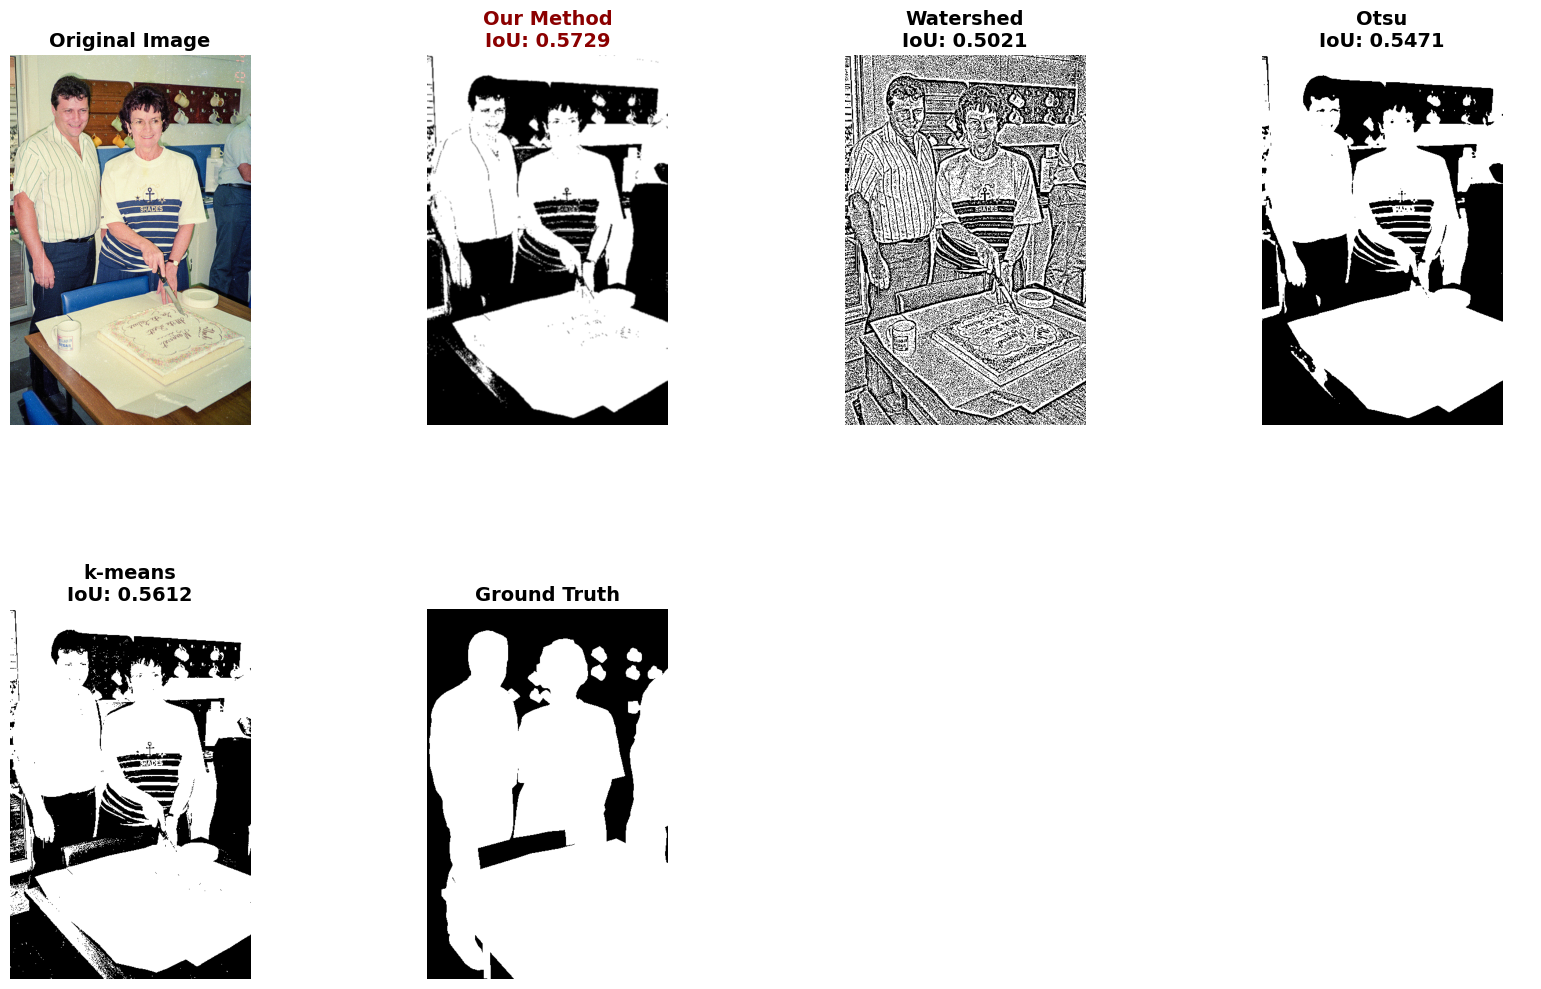

In [30]:
# Apply segmentation algorithms and Calculate IoU scores
adaptive_threshold_result = adaptive_threshold(img.copy())
iou_adaptive_threshold = calculate_iou(adaptive_threshold_result, ground_truth)
otsu_result = otsu(img.copy())
iou_otsu = calculate_iou(otsu_result, ground_truth)
kmeans_result = kmeans(img.copy())
iou_kmeans = calculate_iou(kmeans_result, ground_truth)
our_result = segment_image(img.copy())
iou_our = calculate_iou(our_result, ground_truth)
fig, axs = plt.subplots(2, 4, figsize=(20, 12))
fig.subplots_adjust(wspace=0.4, hspace=0.5)

# Original image
axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image', fontsize=14, weight='bold')
axs[0, 0].axis('off')
axs[0, 0].spines['top'].set_linewidth(1)
axs[0, 0].spines['top'].set_color('black')

# Our Method
axs[0, 1].imshow(our_result, cmap='gray')
axs[0, 1].set_title(f'Our Method\nIoU: {iou_our:.4f}', fontsize=14, weight='bold', color='darkred')
axs[0, 1].axis('off')
axs[0, 1].spines['top'].set_linewidth(1)
axs[0, 1].spines['top'].set_color('black')

# Watershed
axs[0, 2].imshow(adaptive_threshold_result, cmap='gray')
axs[0, 2].set_title(f'Watershed\nIoU: {iou_adaptive_threshold:.4f}', fontsize=14, weight='bold')
axs[0, 2].axis('off')
axs[0, 2].spines['top'].set_linewidth(1)
axs[0, 2].spines['top'].set_color('black')

# Otsu's Thresholding
axs[0, 3].imshow(otsu_result, cmap='gray')
axs[0, 3].set_title(f'Otsu\nIoU: {iou_otsu:.4f}', fontsize=14, weight='bold')
axs[0, 3].axis('off')
axs[0, 3].spines['top'].set_linewidth(1)
axs[0, 3].spines['top'].set_color('black')

# k-means 
axs[1, 0].imshow(kmeans_result, cmap='gray')
axs[1, 0].set_title(f'k-means\nIoU: {iou_kmeans:.4f}', fontsize=14, weight='bold')
axs[1, 0].axis('off')
axs[1, 0].spines['top'].set_linewidth(1)
axs[1, 0].spines['top'].set_color('black')

# Ground truth
axs[1, 1].imshow(ground_truth, cmap='gray')
axs[1, 1].set_title('Ground Truth', fontsize=14, weight='bold')
axs[1, 1].axis('off')
axs[1, 1].spines['top'].set_linewidth(1)
axs[1, 1].spines['top'].set_color('black')

for i in range(1, 4):
    axs[1, i].axis('off')
plt.show()
